In [1]:
import requests
import pandas as pd
import subprocess
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.utils import get_column_letter
import openpyxl
import json
from utils import *

### 1 Load Production Data in most granular form

#### Load API credentials from local file

In [2]:
# Load credentials (keep them in file on local machine)
with open('0_credentials.json') as cred_file:
    HEADERS = json.load(cred_file)

In [3]:
# Load information about PV installations
dict_inst = pd.read_excel("1_Installations.xlsx",
                        index_col=0).to_dict("index")

For every PV installation, download all or the latest data and save to raw data files:

In [ ]:
create_excel_files_from_scratch = False   # if data should be downloaded from the very beginning (use if no file existing yet)

# Check if there is an Excel file for the given installation
for site_name, site_info in dict_inst.items():
    ls_pod = [val for key, val in site_info.items() if "POD_" in key and pd.notna(val)]
    for pod in ls_pod:
        try:
            df_raw = pd.read_excel(f"0_Raw_production_data_per_installation\{site_name}_{pod}.xlsx", 
                                    index_col=0)
            # If yes, check for the latest date with data
            # Data for autconsumption sites has lag for locally consumed energy
            if site_info["Mode (Autoconsumption/Injection)"] == "Autoconsumption":
                df_raw["startedAt_remaining_production_after_sharing"] = pd.to_datetime(df_raw["startedAt_remaining_production_after_sharing"])
                start_date = df_raw["startedAt_remaining_production_after_sharing"].max()
            else:
                df_raw["startedAt_measured_active_production"] = pd.to_datetime(df_raw["startedAt_measured_active_production"])
                start_date = df_raw["startedAt_measured_active_production"].max()
            
        except FileNotFoundError:
            print(f"File {site_name}_{pod}.xlsx not found. Downloading data.")
            start_date = "2020-01-01T00:00:00Z"
        
        if create_excel_files_from_scratch: 
            start_date = "2020-01-01T00:00:00Z"

        # Download data since then to yesterday (data is published up to last quarter hour of 3 days ago for consumption, and up to last quarter hour of yesterday for production)
        end_date = (datetime.now() - pd.DateOffset(days=3)).strftime("%Y-%m-%dT22:45:00Z")
        if pd.to_datetime(end_date) <= pd.to_datetime(start_date):
            print(f"No new data for {site_name}_{pod}.")
            continue
        else:
            df_inst = process_api_data(HEADERS=HEADERS, 
                                    pod=pod,
                                    start_date=start_date, 
                                    end_date=end_date)
            # Update the file
            if create_excel_files_from_scratch:
                df_inst.to_excel(f"0_Raw_production_data_per_installation\{site_name}_{pod}.xlsx")
            else:
                df_raw["startedAt_measured_active_production"] = pd.to_datetime(df_raw["startedAt_measured_active_production"])
                start_date = pd.to_datetime(start_date)
                end_date = pd.to_datetime(end_date)
                if 'df_raw' in locals():
                    df_raw = pd.concat([df_raw[df_raw["startedAt_measured_active_production"]<start_date], 
                                        df_inst])
                else:
                    df_raw = df_inst
                df_raw.drop_duplicates(inplace=True)
                df_raw.reset_index(drop=True).to_excel(f"0_Raw_production_data_per_installation\{site_name}_{pod}.xlsx")

No new data for Steinsel Ecole_LU0000010733900000000000770597811.
Error fetching data for LU0000010734000000000000770603768: 404 Client Error: Not Found for url: https://api.leneda.eu/api/metering-points/LU0000010734000000000000770603768/time-series?startDateTime=2025-03-12+22%3A45%3A00%2B00%3A00&endDateTime=2025-03-14T22%3A45%3A00Z&obisCode=1-1%3A2.29.0
Error fetching data for LU0000010734000000000000770603768: 404 Client Error: Not Found for url: https://api.leneda.eu/api/metering-points/LU0000010734000000000000770603768/time-series?startDateTime=2025-03-12+22%3A45%3A00%2B00%3A00&endDateTime=2025-03-14T22%3A45%3A00Z&obisCode=1-65%3A2.29.9


ValueError: Excel does not support datetimes with timezones. Please ensure that datetimes are timezone unaware before writing to Excel.

## 2 Transform 15-minute data into monthly summaries

In [ ]:
# For every installation, calculate the monthly summaries
dict_monthly_summaries = {}

for site_name, site_info in dict_inst.items():
    ls_pod = [val for key, val in site_info.items() if "POD_" in key and pd.notna(val)]
    ls_df = []
    for pod in ls_pod:
        df = pd.read_excel(f"0_Raw_production_data_per_installation\{site_name}_{pod}.xlsx", 
                        index_col=0)
        ls_df.append(df)
    df_raw = pd.concat(ls_df)
    columns_to_sum = ["value_measured_active_production", 
                    "value_remaining_production_after_sharing"]
    df_raw = df_raw.groupby('startedAt_measured_active_production', as_index=False).agg(
                                                                {col: 'sum' if col in columns_to_sum else 'first' for col in df_raw.columns}
                                                            )
    
    # LU VAT rate is 0.07 for all dates prior to 2024
    # and 0.08 for all dates after 2024
    df_raw["VAT Rate"] = np.where(pd.to_datetime(df_raw["startedAt_measured_active_production"]).dt.year < 2024, 0.07, 0.08)
    
    if site_info["Mode (Autoconsumption/Injection)"] == "Autoconsumption":
        # Cut off analysis at the last complete month, as production data and consumption data are lagged
        last_complete_month = pd.to_datetime(df_raw["startedAt_remaining_production_after_sharing"]).max().replace(day=1) - pd.DateOffset(months=1)
        df_raw = df_raw[pd.to_datetime(df_raw["startedAt_remaining_production_after_sharing"]) <= last_complete_month + pd.DateOffset(months=1, days=-1)]
    
    dict_monthly_summaries[site_name] = calculate_monthly_summaries(df_site=df_raw, 
                                                                    autoconsumption=site_info["Mode (Autoconsumption/Injection)"],
                                                                    autoconsumption_price=site_info["Autoconsumption power price [EUR/kWh]"])

## 3 Save monthly data to formatted Excel

In [ ]:
for site_name, site_info in dict_inst.items():
    ls_pod = [val for key, val in site_info.items() if "POD_" in key and pd.notna(val)]
    if len(ls_pod)==1:
        pod = ls_pod[0]
    else:
        pod = "_".join(ls_pod)
    process_sheet(  site_name, 
                    site_info,
                    pod,
                    format_monthly_data(dict_monthly_summaries[site_name]), 
                    sheet_type=site_info["Mode (Autoconsumption/Injection)"].lower()
                    )

## 4 Generate invoices for PV installations with autoconsumption

In [ ]:
idx = 1
for inst, df_m in dict_monthly_summaries.items():
    if dict_inst[inst]["Mode (Autoconsumption/Injection)"] == "Autoconsumption":
        mask = (df_m["Year"] == 2025) & (df_m["Month"].isin(["January", "February", "March"]))
        generate_invoice_for_site(inst,
                                  df_m[mask], 
                                  idx)
        idx += 1


### 5 Add production analysis

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for inst, df_m in dict_monthly_summaries.items():
    if dict_inst[inst]["Mode (Autoconsumption/Injection)"] == "Autoconsumption":
        # Create a new column "Month-Year"
        dict_monthly_summaries[inst]["Month-Year"] = dict_monthly_summaries[inst]["Month"] + " " + dict_monthly_summaries[inst]["Year"].astype(str)

        # Plot the data
        dict_monthly_summaries[inst][["Self-Consumption", "Grid Injection", "Month-Year"]].plot(
            kind="bar",
            stacked=True,
            title="Grid Injection and Self-Consumption for " + inst + ", " + str(dict_inst[inst]['Capacity [kWp]']) + " kWp",
            ylabel="kWh",
            xlabel="Month-Year",
            figsize=(10, 5),
            grid=False,
            legend=True,
            x="Month-Year"
            )

In [ ]:
# Filter for installations that have autoconsumption
combined_df = pd.concat(dict_monthly_summaries.values(), keys=dict_monthly_summaries.keys(), names=['Installation', 'Index'])
autoconsumption_df = combined_df[combined_df.index.get_level_values('Installation').isin(
    [name for name, info in dict_inst.items() if info["Mode (Autoconsumption/Injection)"] == "Autoconsumption"]
)]

# Extract all self-consumption columns
self_consumption_columns = [col for col in autoconsumption_df.columns if 'Self-Consumption Ratio' in col]

# Plot the data
plt.figure(figsize=(15, 7))
colors = plt.cm.get_cmap('tab10', len(autoconsumption_df.index.get_level_values('Installation').unique()))

for idx, installation in enumerate(autoconsumption_df.index.get_level_values('Installation').unique()):
    projected_self_consumption_ratio = dict_inst[installation]["Projected self-consumption ratio"]
    color = colors(idx)
    plt.axhline(y=projected_self_consumption_ratio, linestyle='--', label=f'{installation} Projected Ratio', color=color)
    df_plot = autoconsumption_df.loc[installation, self_consumption_columns]
    plt.plot(df_plot.index, df_plot, label=installation, color=color)

plt.title('Self-Consumption Ratio for All Installations')
plt.ylabel('Self-Consumption Ratio')
plt.xlabel('Month-Year')
plt.grid(True)
plt.legend()
plt.ylim(0, 1.1)
plt.show()


### 6 Compare actual vs. projected annual production

In [ ]:
# Determine the number of installations to plot
num_installations = len(dict_monthly_summaries)
num_cols = 2
num_rows = (num_installations + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, (inst, df_m) in enumerate(dict_monthly_summaries.items()):
    # Get the start of production year
    start_year = dict_inst[inst]['Start of production'].year
    start_year = max(2022, start_year)  # Leneda data reaches back to end of 2022 only -> only account for full years
    
    # Filter for complete years after the start of production
    df_m = df_m[df_m.index.year > start_year]
    df_m = df_m[df_m.index.year < datetime.now().year]
    
    # Calculate actual annual production
    actual_annual_production = df_m.resample('Y').sum()['Production']
    
    # Get projected annual production
    projected_annual_production = dict_inst[inst]['Projected annual production [kWh]']
    
    # Compare actual vs. projected
    comparison_df = pd.DataFrame({
        'Actual Production': actual_annual_production,
        'Projected Production': [projected_annual_production] * len(actual_annual_production)
    })
    comparison_df = comparison_df[['Projected Production', 'Actual Production']]
    
    # Plot the comparison
    comparison_df.plot(kind='bar', ax=axes[idx], title=f'{inst}, {dict_inst[inst]["Capacity [kWp]"]} kWp')
    comparison_df["Year"] = comparison_df.index.year.astype(int)
    axes[idx].set_ylabel('kWh')
    axes[idx].set_xlabel('Year')
    axes[idx].set_xticklabels(comparison_df["Year"].astype(str))
    axes[idx].grid(True)
    axes[idx].legend(loc='lower right')

# Remove any unused subplots
for ax in axes[num_installations:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

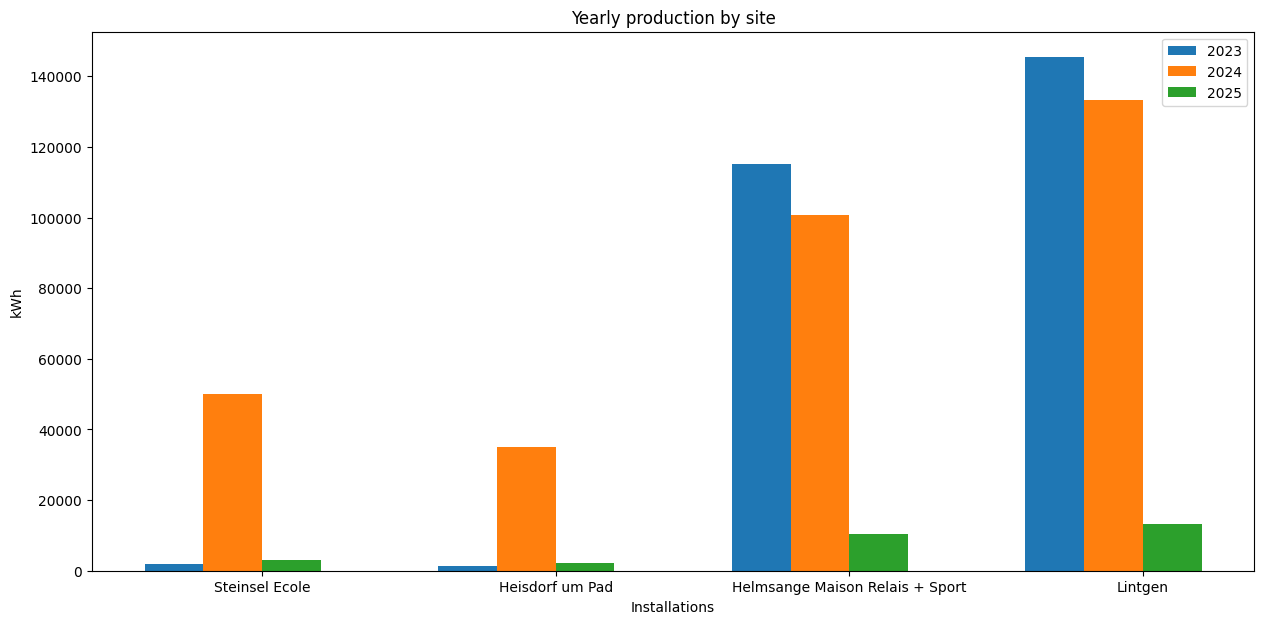

In [ ]:
# Sample data
installations = list(dict_inst.keys())

# Compute yearly production data from dict_monthly_summaries
years = sorted(set(year for df_m in dict_monthly_summaries.values() for year in df_m.index.year if year > 2022))  # Only consider years after 2022 as Leneda data starts in 2023
production_data = {inst: [df_m[df_m.index.year == year]['Production'].sum() for year in years] for inst, df_m in dict_monthly_summaries.items()}

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

bar_width = 0.2
index = range(len(installations))

for i, year in enumerate(years):
    production = [production_data.get(inst, [0]*len(years))[i] for inst in installations]
    ax.bar([p + bar_width * i for p in index], production, bar_width, label=year)

ax.set_xlabel('Installations')
ax.set_ylabel('kWh')
ax.set_title('Yearly production by site')
ax.set_xticks([p + bar_width * 1.5 for p in index])
ax.set_xticklabels(installations)
ax.legend()

plt.show()


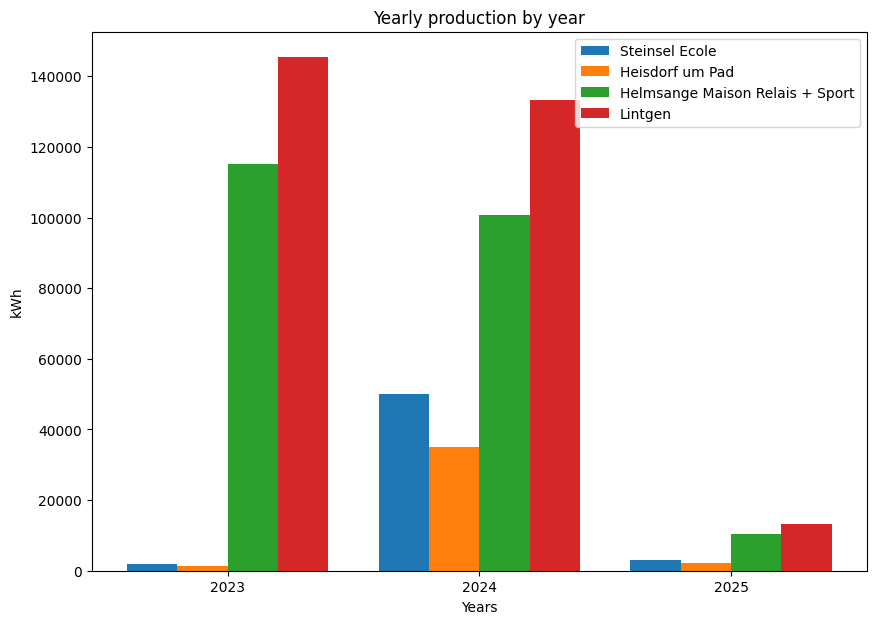

In [ ]:
# Sample data
installations = list(dict_inst.keys())

# Compute yearly production data from dict_monthly_summaries
years = sorted(set(year for df_m in dict_monthly_summaries.values() for year in df_m.index.year if year > 2022))  # Only consider years after 2022 as Leneda data starts in 2023
production_data = {inst: [df_m[df_m.index.year == year]['Production'].sum() for year in years] for inst, df_m in dict_monthly_summaries.items()}

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

bar_width = 0.2
index = range(len(years))

for i, inst in enumerate(installations):
    production = production_data.get(inst, [0]*len(years))
    ax.bar([p + bar_width * i for p in index], production, bar_width, label=inst)

ax.set_xlabel('Years')
ax.set_ylabel('kWh')
ax.set_title('Yearly production by year')
ax.set_xticks([p + bar_width * 1.5 for p in index])
ax.set_xticklabels(years)
ax.legend()

plt.show()
